#  ONLY IN CASE OF GOOGLE COLAB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Github/ModelComparisons_MA
!git pull

from google.colab.patches import cv2_imshow

Mounted at /content/drive
/content/drive/MyDrive/Github/ModelComparisons_MA
Already up to date.


# Training a model with the custom training loop

In [ ]:
from utils import DataSet
import utils.augmentation as aug
import utils.helpers as helpers

In [ ]:
!pip install mean_average_precision

import torch, torchvision 
import albumentations as A
import cv2
import numpy as np 
import pandas as pd
import os, random, time, json, math
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from sklearn.model_selection import train_test_split
from mean_average_precision import MetricBuilder
from tqdm.auto import tqdm



from ImageEnhancement import MSRCR, FUSION, CLAHE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
BATCH_SIZE = 10 # increase / decrease according to GPU memeory
RESIZE_TO = 800 # resize the image for training and transforms
NUM_EPOCHS = 15 # number of epochs to train for
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# training images and XML files directory
SEED = 42
TEST_RATIO = 0.1 # for train/test split

MAPPING = {
    'DUMMY': 0,
    'Fish': 1,
    'Cnidaria':2   
}

# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = False
# location to save model and plots
#OUT_DIR = '/home/anton/Documents/Thesis/temResults'
OUT_DIR = "/content/res"
SAVE_PLOTS_EPOCH = 5 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 5 # save model after these many epochs

PREPARE_TEST_DATA = True

IMAGE_DIRECTORY = "images"

In [ ]:
# Getting all relevant paths for images and their respective label files and splitting them 
#      into train and validation datasets

#base_dir = "/home/anton/Downloads/image_annotator/linux_v1.4.3/data/oldclean/"
base_dir = "/content/drive/MyDrive/ROV_ECIM/multimedia/ECIM_bruv_data"
imgs, labels = helpers.image_and_label_paths(base_dir, image_dir = "images", label_dir = "labels")
inputs_train, inputs_valid, targets_train, targets_valid = train_test_split(imgs, labels, test_size=TEST_RATIO, random_state=SEED)


In [ ]:
# Train DataSet:
# Augmentations from the Albumentations library
albumentations_augmentations = A.Compose([ A.Flip(0.45), A.RandomRotate90(0.5),
                                           A.MotionBlur(p=0.2), A.Blur(blur_limit=3, p=0.1)],
                                         bbox_params={  'format': 'pascal_voc', 
                                                        'label_fields': ['labels']}
                                        )

# custum augmentations combined with those from the library
my_albumenations = aug.Augmenter([aug.Clip, aug.Resize(800, 800), aug.Normalize], 
                                                 albumentations_augmentations)

# create DataSet with correct sample lists
train_dataset = DataSet(inputs_train, 
                            targets_train, 
                            use_cache          = False,
                            transform          = my_albumenations,
                            mapping            = MAPPING,
                            random_enhancement = False
                            )



# Validation DataSet:
# Augmentations from the Albumentations library
albumentations_augmentations = A.Compose([],bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# custum augmentations combined with those from the library
my_albumenations = aug.Augmenter([aug.Clip, aug.Resize(800, 800), aug.Normalize], 
                                                 albumentations_augmentations)


# create DataSet object with correct sample lists
validation_dataset = DataSet(inputs_valid, 
                                targets_valid, 
                                use_cache          = False,
                                transform          = my_albumenations,
                                mapping            = MAPPING, 
                                random_enhancement = False)          

# Example for accessing entries in a DataSet object:
#train_dataset[0]


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

# A Torch dataloader takes our dataset object to successively extract same sized batches from it 
train_loader = DataLoader(  dataset     = train_dataset,
                            batch_size  = BATCH_SIZE,
                            shuffle     = True,
                            num_workers = 0,
                            collate_fn  = collate_fn
                         )


valid_loader = DataLoader(  dataset     = validation_dataset,
                            batch_size  = BATCH_SIZE,
                            shuffle     = False,
                            num_workers = 0,
                            collate_fn  = collate_fn
                         )

#train_loss_hist = Averager()
#val_loss_hist = Averager()


In [ ]:
# function that creates model objects and download pretrained weights
def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [ ]:
# function that executes training for one epoch
def train(train_data_loader, model, optimizer, train_itr, train_loss_list):
    print('Training')
    loss_avg = 0
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items() if k in ["boxes", "labels"]} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        loss_avg += loss_value
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list, train_itr, (1.0*loss_avg)/len(train_data_loader)

# function that executes validation for one epoch
def validate(valid_data_loader, model, val_itr, val_loss_list):
    print('Validating')
    loss_avg = 0
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items() if k in ["boxes", "labels"]} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        loss_avg += loss_value
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list, val_itr, (1.0*loss_avg)/len(valid_data_loader)


EPOCH 1 of 15
Training


  0%|          | 0/8 [00:00<?, ?it/s]

Validating


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #0 train loss: 1.544
Epoch #0 validation loss: 1.095
Took 0.194 minutes for epoch 0

EPOCH 2 of 15
Training


  0%|          | 0/8 [00:00<?, ?it/s]

Validating


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #1 train loss: 1.031
Epoch #1 validation loss: 0.880
Took 0.193 minutes for epoch 1

EPOCH 3 of 15
Training


  0%|          | 0/8 [00:00<?, ?it/s]

Validating


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #2 train loss: 0.836
Epoch #2 validation loss: 0.756
Took 0.193 minutes for epoch 2

EPOCH 4 of 15
Training


  0%|          | 0/8 [00:00<?, ?it/s]

Validating


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #3 train loss: 0.759
Epoch #3 validation loss: 0.684
Took 0.192 minutes for epoch 3

EPOCH 5 of 15
Training


  0%|          | 0/8 [00:00<?, ?it/s]

Validating


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #4 train loss: 0.692
Epoch #4 validation loss: 0.692
Took 0.192 minutes for epoch 4
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 6 of 15
Training


  0%|          | 0/8 [00:00<?, ?it/s]

Validating


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #5 train loss: 0.672
Epoch #5 validation loss: 0.614
Took 0.216 minutes for epoch 5

EPOCH 7 of 15
Training


  0%|          | 0/8 [00:00<?, ?it/s]

Validating


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #6 train loss: 0.633
Epoch #6 validation loss: 0.601
Took 0.191 minutes for epoch 6

EPOCH 8 of 15
Training


  0%|          | 0/8 [00:00<?, ?it/s]

Validating


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #7 train loss: 0.615
Epoch #7 validation loss: 0.607
Took 0.193 minutes for epoch 7

EPOCH 9 of 15
Training


  0%|          | 0/8 [00:00<?, ?it/s]

Validating


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #8 train loss: 0.600
Epoch #8 validation loss: 0.607
Took 0.193 minutes for epoch 8

EPOCH 10 of 15
Training


  0%|          | 0/8 [00:00<?, ?it/s]

Validating


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #9 train loss: 0.598
Epoch #9 validation loss: 0.605
Took 0.194 minutes for epoch 9
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 11 of 15
Training


  0%|          | 0/8 [00:00<?, ?it/s]

Validating


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #10 train loss: 0.567
Epoch #10 validation loss: 0.584
Took 0.193 minutes for epoch 10

EPOCH 12 of 15
Training


  0%|          | 0/8 [00:00<?, ?it/s]

Validating


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #11 train loss: 0.556
Epoch #11 validation loss: 0.574
Took 0.191 minutes for epoch 11

EPOCH 13 of 15
Training


  0%|          | 0/8 [00:00<?, ?it/s]

Validating


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #12 train loss: 0.567
Epoch #12 validation loss: 0.590
Took 0.192 minutes for epoch 12

EPOCH 14 of 15
Training


  0%|          | 0/8 [00:00<?, ?it/s]

Validating


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #13 train loss: 0.548
Epoch #13 validation loss: 0.585
Took 0.192 minutes for epoch 13

EPOCH 15 of 15
Training


  0%|          | 0/8 [00:00<?, ?it/s]

Validating


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch #14 train loss: 0.536
Epoch #14 validation loss: 0.589
Took 0.195 minutes for epoch 14
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...


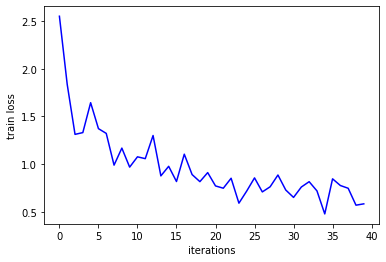

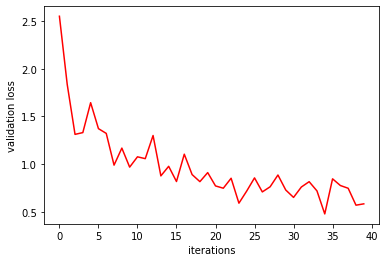

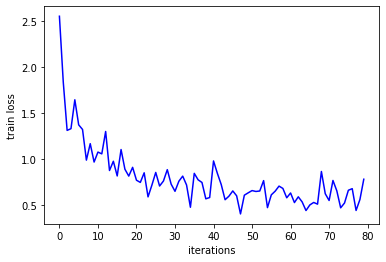

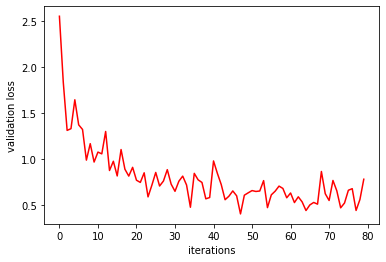

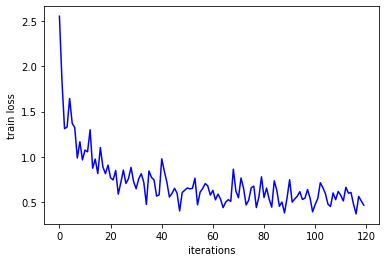

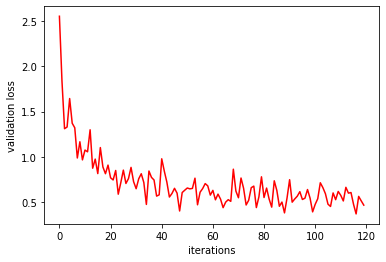

In [ ]:
MODEL_NAME = 'model'
MODEL_APPENDIX = "RANDOM_FINAL"

model = create_model(num_classes = len(MAPPING.keys()) )

### FOR IMPORTING A MODEL
#model.load_state_dict(torch.load(OUT_DIR+"/FILE-NAME.pth"))
###

model = model.to(DEVICE)

# define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.003, momentum=0.9, weight_decay=0.0001)

train_itr = 1
val_itr = 1
train_loss_list = []
val_loss_list = []


# start the training
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    # start timer and carry out training and validation
    start = time.time()
    train_loss_list, train_itr, train_loss_avg = train(train_loader, model, optimizer, train_itr, train_loss_list)
    val_loss_list, val_itr, val_loss_avg = validate(valid_loader, model, val_itr, val_loss_list)
    print(f"Epoch #{epoch} train loss: {train_loss_avg:.3f}")   
    print(f"Epoch #{epoch} validation loss: {val_loss_avg:.3f}")   
    end = time.time()
    
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    if (epoch+1) % SAVE_MODEL_EPOCH == 0 or (epoch+1) == NUM_EPOCHS: # save model after every n epochs or at end
        torch.save(model.state_dict(), f"{OUT_DIR}/model_{MODEL_APPENDIX}_{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')
    if (epoch+1) % SAVE_PLOTS_EPOCH == 0 or (epoch+1) == NUM_EPOCHS: # save loss plots after n epochs or at end
        figure_1, train_ax = plt.subplots()
        figure_2, valid_ax = plt.subplots()
        train_ax.plot(train_loss_list, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(train_loss_list, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{MODEL_APPENDIX}_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{MODEL_APPENDIX}_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...') 

# MODEL EVALUATION

In [ ]:
#Loads in one of the trained models for evaluation

model_test = create_model(num_classes = len(MAPPING.keys()))
model_test.load_state_dict(torch.load(f"{OUT_DIR}/model_RANDOM_FINAL_15.pth", map_location=torch.device(DEVICE)))
model_test = model_test.to(DEVICE)

In [ ]:
# getting all paths to test images and labels

base_dir = "/content/drive/MyDrive/ROV_ECIM/multimedia/ModelTestData"
inputs_test, targets_test = helpers.image_and_label_paths(base_dir, image_dir = "images", label_dir = "labels")

In [ ]:
# Test DataSet:
# Augmentations from the Albumentations library
albumentations_augmentations = A.Compose([], bbox_params={  'format': 'pascal_voc', 
                                                            'label_fields': ['labels']}
                                        )

# custum augmentations combined with those from the library
my_albumenations = aug.Augmenter([aug.Clip, aug.Resize(800, 800), aug.Normalize], albumentations_augmentations)

# create DataSet with correct sample lists
test_dataset = DataSet(inputs_test, 
                            targets_test, 
                            use_cache          = False,
                            transform          = my_albumenations,
                            mapping            = MAPPING,
                            random_enhancement = False,
                            csv_label_column   = "class"
                            )

In [ ]:
def SaveResultImage(image, ground_truth, predictions, out_path, img_name):
    image = np.moveaxis(image.to("cpu").numpy(), source = 0, destination = -1)*255
    #predb = predictions["boxes"] 
    #real = ground_truth["boxes"]
    image = helpers.boxes_draw(image, ground_truth, size = 5,color = (255,0,0))
    image = helpers.boxes_draw(image, predictions, color = (0,255,0), size = 2)
    print(out_path + "RESULT" +img_name.split("/")[-1])
    cv2.imwrite(out_path + "RESULT" +img_name.split("/")[-1], image)

# function that evaluates the dataset on the loaded model
def evaluate_model( model, 
                    dataset, 
                    device, 
                    evaluation_object, 
                    conf_threshold       = 0.3,
                    save_image_frequency = 0, 
                    save_image_path      = "./"
                   ):
  model.eval()
  save_image_frequency = save_image_frequency if save_image_frequency > 0 else len(dataset) + 1

  prog_bar = tqdm(dataset, total=len(dataset))
  for index, elem in enumerate(prog_bar):
    image, boxes = elem
    targets = {k: v.to(device) for k, v in boxes.items() if k in ["boxes", "labels"]}
    image = image.to(device)

    gts = []   # List of ground Truths for this image in Format [[(x1,y1,x2,y2), labelID, 0, 0], [...], ...]
    for b, l in zip(targets["boxes"], targets["labels"]):
      gts.append(list(b.to("cpu").numpy()) + [l.item()] + [0,0])

    with torch.no_grad():
      pred = model([image])[0]
      prds = [] # List of ground Truths for this image in Format [[(x1,y1,x2,y2), labelID, 0, confScore], [...], ...]
      for b, l, s in zip(pred["boxes"], pred["labels"], pred["scores"]):
        if(s < conf_threshold):
          continue 
        prds.append(list(b.to("cpu").detach().numpy()) + [max(l.item(), 0)] + [s.item()])
    evaluation_object.add(np.array(prds), np.array(gts))
    if((index + 1) % save_image_frequency == 0):  # Save image with bounding boxes if so specified
      SaveResultImage(image, gts, prds, save_image_path, boxes["image_id"])
  return evaluation_object

In [ ]:

evaluation_metric = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=1)
evaluation_metric = evaluate_model(model_test, test_dataset, DEVICE, evaluation_metric, save_image_frequency = 5, save_image_path = "/content/res/")
mAP_ = evaluation_metric.value(np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']

print(mAP_)

  0%|          | 0/35 [00:00<?, ?it/s]

/content/res/RESULTBRUVS_14995819-31f8-404f-adbe-57ace1106ef9.png
/content/res/RESULTBRUVS_4dd4df02-d110-4b38-a4bb-b78dd345adf7.png
/content/res/RESULTBRUVS_Algrraobo_23-12-21_9.png
/content/res/RESULTBRUVS_LasCruces_xx-xx-21_26_x.png
/content/res/RESULTBRUVS_afd60995-a0db-47bf-84bb-5649283a608e.png
/content/res/RESULTMBARI_DATA_4d5c9d90-603f-42da-929f-83dd954eaea8.png
/content/res/RESULTMBARI_DATA_e3dc0077-0932-4855-ba06-cb4974da1bb0.png
0.0
